In [1]:
from fastai.vision.all import *
import torch
from torch import nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18
from time import time
from tqdm import tqdm

lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)  #Dictionary from codified label to explicit ones

# Define the path to the Imagenette dataset
path = untar_data(URLs.IMAGENETTE_160) # load the dataset, from fastai

# Define transformations for the images (to suit the ResNet18 input format)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create DataLoaders
#First seperate
train_dataset = ImageFolder(root=path / 'train', transform=transform) # ImageFolder for training
test_dataset = ImageFolder(root=path / 'val', transform=transform)# ImageFolder for validation

train_dataset.targets = [lbl_dict[i[0].split("/")[6]] for i in train_dataset.samples] #transform labels to explicit ones
test_dataset.targets = [lbl_dict[i[0].split("/")[6]] for i in test_dataset.samples]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4) #create DataLoader by batch of different size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4) #shuffle, because dataset ordered by label


def print_size_of_model(model): #usefull later from Umar Jamil (see README.md for link)
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
import torchvision.models.quantization as tmq #important to quantize this ResNet18, the normal Resnet18 don't receive well quantization

In [4]:
PreQuant_Model2 = tmq.resnet18(quantize=False)
PreQuant_Model2.fc = nn.Linear(PreQuant_Model2.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the model weights
PreQuant_Model2.load_state_dict(torch.load('/content/model_weights.pth'))


PreQuant_Model2.to(device)

#optimizer = optim.SGD(loaded_model.parameters(), lr=0.01, momentum=0.9)
optimizer = Adam(PreQuant_Model2.parameters(), lr=0.001)

# Optionally, load the optimizer state
optimizer.load_state_dict(torch.load('/content/optimizer_state.pth', map_location='cpu'))

# POST TRAINING QUANT

In [5]:
PreQuant_Model2.eval() # set on eval, the model is on not learning.
PreQuant_Model2.qconfig = torch.ao.quantization.default_qconfig #instert observers
PreQuant_Model2 = torch.ao.quantization.prepare(PreQuant_Model2)

PreQuant_Model2.eval()
correct = 0
total = 0
with torch.no_grad(): #compute prediction on the test set
    for inputs, labels in tqdm(test_loader, desc="Test Batches"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = PreQuant_Model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Test Batches:   0%|          | 0/62 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Test Batches: 100%|██████████| 62/62 [07:34<00:00,  7.33s/it]

Accuracy on the test set: 68.97%


In [6]:
import torch.quantization
Quant_Model2 = torch.ao.quantization.convert(PreQuant_Model2) #quantize models based on observation made during the test

In [7]:
Quant_Model2.eval() #try to evaluate this quantize model
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test Batches"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = Quant_Model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Test Batches: 100%|██████████| 62/62 [03:26<00:00,  3.33s/it]

Accuracy on the test set: 68.54%


In [9]:
print_size_of_model(PreQuant_Model2)# compare size normal  model
print(" ")                                     #vs
print_size_of_model(Quant_Model2)           # Quantized

Size (KB): 44854.03
 
Size (KB): 11319.068


The following time number will probably change next time but will be quite close, the two other will be the same

In [11]:
f'{round(7.33/3.33,2)} times faster and {round(100*(11319.068/44854.03),2)}% of the size for a loss of only {round(68.97 - 68.54,2)}% of the precision'

'2.2 times faster and 25.24% of the size for a loss of only 0.43% of the precision'

# QUANT AWARE TRAINING

In [66]:
PreQuant_Model3 = PreQuant_Model2 #copy the model

In [67]:
PreQuant_Model3.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm') #Prepare it QAW https://pytorch.org/tutorials/recipes/quantization.html
PreQuant_Model3 = torch.quantization.prepare_qat(PreQuant_Model3, inplace=False)

# DO NOT RERUN it will take an 45 minutes to retrain one epoch

In [69]:
PreQuant_Model3.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(PreQuant_Model3.parameters(), lr=0.001)

# Training loop
#The initial model was initialise that way
num_epochs = 1
start_time = time()
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    PreQuant_Model3.train() #when set on train the model
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc="Batches", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = PreQuant_Model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


PreQuant_Model3_qat = torch.quantization.convert(PreQuant_Model3.eval(), inplace=False) # quantize the model after the QAT

# Save the entire model, uncomment if you want to save the weights
#torch.save(PreQuant_Model3.state_dict(), 'model_weightsQPA.pth')
#torch.save(PreQuant_Model3_qat.state_dict(), 'model_weightsQPAQuant.pth')
#torch.save(optimizer.state_dict(), 'optimizer_stateQPA.pth')

Epochs: 100%|██████████| 1/1 [46:47<00:00, 2807.10s/it]


Epoch 1/1, Loss: 0.8225482738501316


QAW Evaluation

In [70]:
PreQuant_Model3_qat.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test Batches"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = PreQuant_Model3_qat(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Test Batches: 100%|██████████| 62/62 [03:16<00:00,  3.17s/it]

Accuracy on the test set: 60.99%


Let's check if the normal model has drop signficantally

In [72]:
PreQuant_Model3.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Test Batches"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = PreQuant_Model3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Test Batches: 100%|██████████| 62/62 [07:14<00:00,  7.00s/it]

Accuracy on the test set: 64.94%


Both of them have drop but the gap is much wider now than before

Let's visualise some exemples

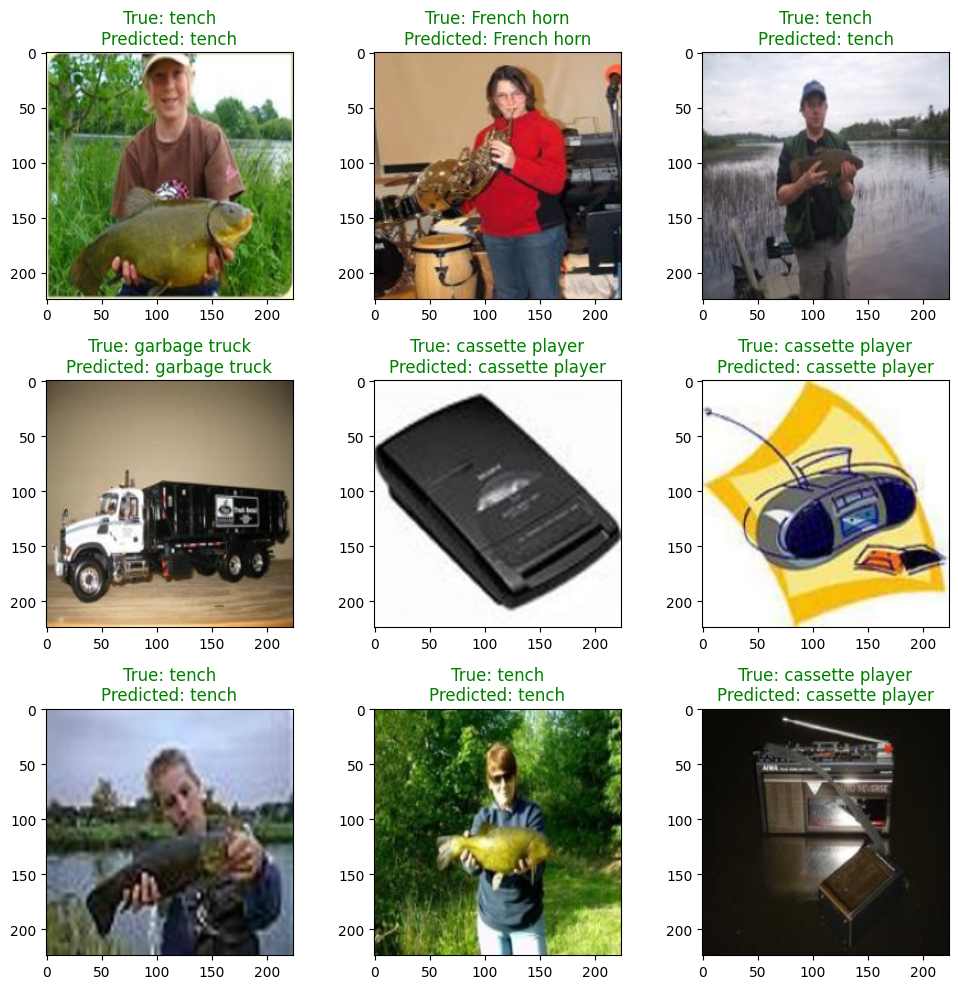

Precision: 100.0%


In [78]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid

# Set the model to evaluation mode so it does not learn on the test set
Quant_Model2.eval()

n = 9
juste = 0

# Create a subplot with a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Choose a random sample from the test set
for i in range(n):
    sample_idx = np.random.randint(len(test_loader.dataset))
    sample_image, sample_label = test_loader.dataset[sample_idx]

    # Move the sample to the device
    sample_image = sample_image.to(device)
    # sample_label = sample_label.to(device)

    # Make the prediction
    with torch.no_grad():
        model_output = Quant_Model2(sample_image.unsqueeze(0))  # Add batch dimension

    # Get the predicted label
    _, predicted_label = torch.max(model_output.data, 1)

    # Set title color based on correctness
    title_color = 'green' if sample_label == predicted_label.item() else 'red'

    # Display the image in the subplot
    row = i // 3
    col = i % 3
    axs[row, col].imshow(transforms.ToPILImage()(sample_image.cpu()))
    axs[row, col].set_title(f"True: {lbl_dict[test_loader.dataset.classes[sample_label]]}\nPredicted: {lbl_dict[test_loader.dataset.classes[predicted_label.item()]]}", color=title_color)
    if sample_label == predicted_label.item():
        juste += 1

# Adjust layout to prevent clipping
plt.tight_layout()


plt.show()

print(f'Precision: {100 * juste / n}%')


We test what happens if we have random model, without trained weights

In [77]:
model_test = tmq.resnet18(quantize=False)
model_test.fc = nn.Linear(model_test.fc.in_features, 10)

model_test.fc.to(device) #intialise a Resnet18 with random weights

Linear(in_features=512, out_features=10, bias=True)

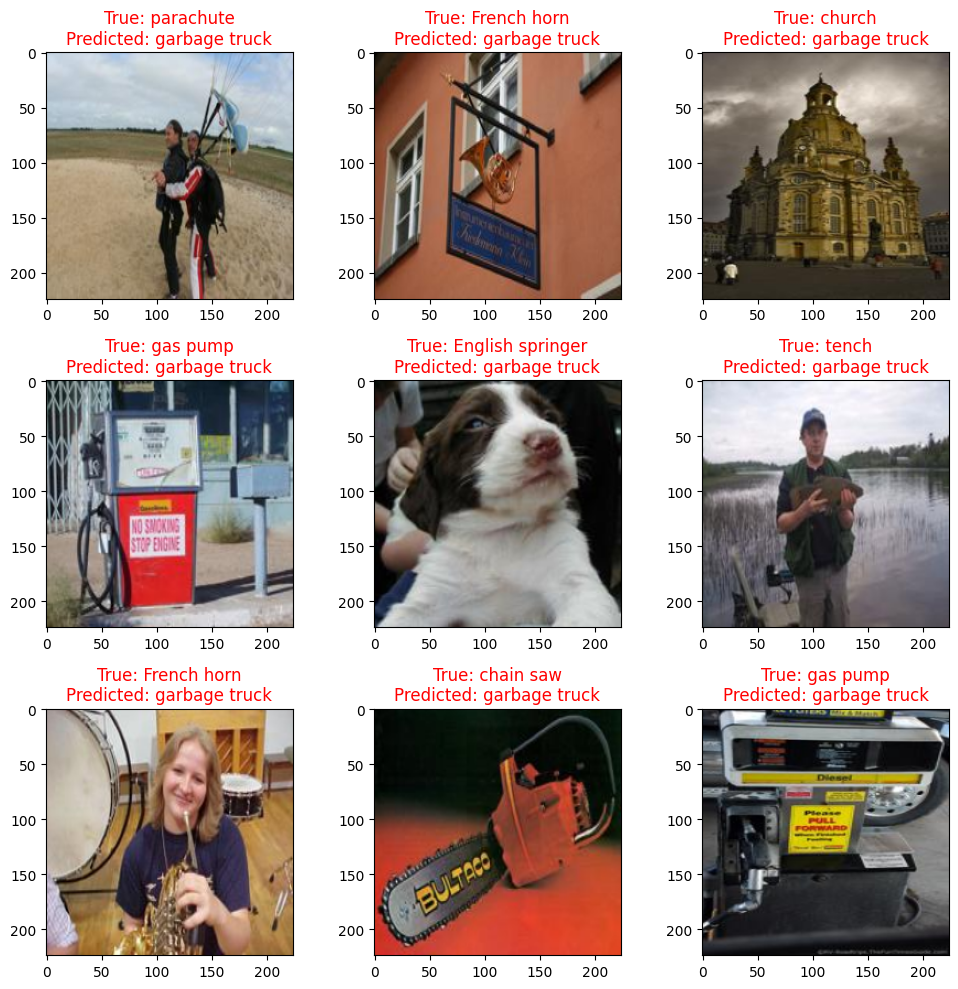

Precision: 0.0%


In [79]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid

# Set the model to evaluation mode
model_test.eval()

n = 9
juste = 0

# Create a subplot with a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Choose a random sample from the test set
for i in range(n):
    sample_idx = np.random.randint(len(test_loader.dataset))  # Change this index as needed
    sample_image, sample_label = test_loader.dataset[sample_idx]

    # Move the sample to the device
    sample_image = sample_image.to(device)
    # sample_label = sample_label.to(device)

    # Make the prediction
    with torch.no_grad():
        model_output = model_test(sample_image.unsqueeze(0))  # Add batch dimension

    # Get the predicted label
    _, predicted_label = torch.max(model_output.data, 1)

    # Set title color based on correctness
    title_color = 'green' if sample_label == predicted_label.item() else 'red'

    # Display the image in the subplot
    row = i // 3
    col = i % 3
    axs[row, col].imshow(transforms.ToPILImage()(sample_image.cpu()))
    axs[row, col].set_title(f"True: {lbl_dict[test_loader.dataset.classes[sample_label]]}\nPredicted: {lbl_dict[test_loader.dataset.classes[predicted_label.item()]]}", color=title_color)
    if sample_label == predicted_label.item():
        juste += 1

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

print(f'Precision: {100 * juste / n}%')

Completely wrong